In [ ]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('geolocation.csv', 'geolocation'),
    ('order_items.csv', 'order_items'),
    ('orders.csv', 'orders'),
    ('payments.csv', 'payments'),
    ('products.csv', 'products'), 
    ('sellers.csv','sellers')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Darshu@#0917',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/darsh/OneDrive/Desktop/portfolio project'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()


Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np


db=mysql.connector.connect(host="localhost",
                           username="root",
                           password="Darshu@#0917",
                           database="ecommerce")
cur=db.cursor()



List all unique cities where customers are located.


In [50]:
query="""select distinct customer_city from customers"""
cur.execute(query)
data=cur.fetchall()
data

[('franca',),
 ('sao bernardo do campo',),
 ('sao paulo',),
 ('mogi das cruzes',),
 ('campinas',),
 ('jaragua do sul',),
 ('timoteo',),
 ('curitiba',),
 ('belo horizonte',),
 ('montes claros',),
 ('rio de janeiro',),
 ('lencois paulista',),
 ('caxias do sul',),
 ('piracicaba',),
 ('guarulhos',),
 ('pacaja',),
 ('florianopolis',),
 ('aparecida de goiania',),
 ('santo andre',),
 ('goiania',),
 ('cachoeiro de itapemirim',),
 ('sao jose dos campos',),
 ('sao roque',),
 ('camacari',),
 ('resende',),
 ('sumare',),
 ('novo hamburgo',),
 ('sao luis',),
 ('sao jose',),
 ('santa barbara',),
 ('ribeirao preto',),
 ('ituiutaba',),
 ('taquarituba',),
 ('sao jose dos pinhais',),
 ('barrinha',),
 ('parati',),
 ('dourados',),
 ('trindade',),
 ('cascavel',),
 ('fortaleza',),
 ('brasilia',),
 ('pelotas',),
 ('porto alegre',),
 ('salto',),
 ('jundiai',),
 ('cacapava',),
 ('sao vicente',),
 ('uberlandia',),
 ('botelhos',),
 ('sao goncalo',),
 ('araucaria',),
 ('nova iguacu',),
 ('areia branca',),
 ('campo

 Count the number of orders placed in 2017.

In [51]:
query="""select count(order_id) from orders where year(order_purchase_timestamp)=2017"""
cur.execute(query)
data=cur.fetchall()
data[0][0]

135303

 Find the total sales per category.

In [52]:
query="""select upper(products.product_category) category,sum(payments.payment_value) sales
from products join order_items
on products.product_id=order_items.product_id
join payments
on payments.order_id =order_items.order_id
group by category"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['category','sales'])
df

,category,sales
0,PERFUMERY,4.560648e+06
1,FURNITURE DECORATION,1.287159e+07
2,TELEPHONY,4.381938e+06
3,BED TABLE BATH,1.541298e+07
4,AUTOMOTIVE,7.670649e+06
...,...,...
69,CDS MUSIC DVDS,1.079487e+04
70,LA CUISINE,2.622177e+04
71,FASHION CHILDREN'S CLOTHING,7.071030e+03
72,PC GAMER,1.956987e+04


 Calculate the percentage of orders that were paid in installments.

In [16]:
query="""select (sum(case when payment_installments>=1 then 1 else 0 end))/count(*)*100 from payments"""
cur.execute(query)
data=cur.fetchall()
data[0][0]

Decimal('99.9981')

Count the number of customers from each state.

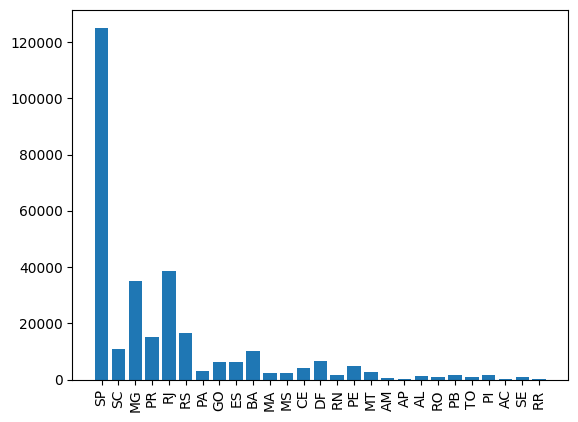

In [22]:
query="""select customer_state,count(customer_id) from customers group by customer_state"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["state","customer_count"])
df
plt.bar(df["state"],df["customer_count"])
plt.xticks(rotation=90)
plt.show()

Calculate the number of orders per month in 2018.

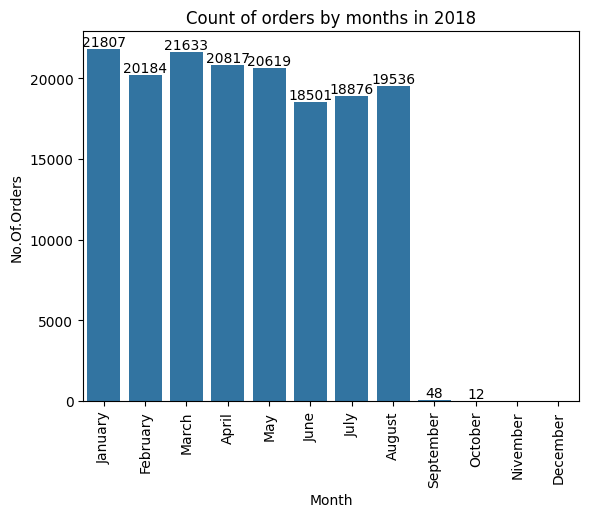

In [37]:
query="""select monthname(order_purchase_timestamp)months,count(order_id)order_count 
from orders where year(order_purchase_timestamp)=2018
group by months"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["Month","No.Of.Orders"])
o=["January","February","March","April","May","June","July","August","September","October","Nivember","December"]
ax=sns.barplot(x=df["Month"],y=df["No.Of.Orders"],data=df,order=o)
plt.xticks(rotation=90)
ax.bar_label(ax.containers[0])
plt.title("Count of orders by months in 2018")
plt.show()

Find the average number of products per order, grouped by customer city.

In [43]:
query="""with count_per_order as
(select orders.order_id,orders.customer_id,count(order_items.order_id)as oc
from orders join order_items
on orders.order_id=order_items.order_id
group by orders.order_id,orders.customer_id)

select customers.customer_city,round(avg(count_per_order.oc),2)average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["customer city","average orders"])
df

,customer city,average orders
0,sao paulo,10.41
1,sao jose dos campos,10.25
2,porto alegre,10.57
3,indaial,10.04
4,treze tilias,11.45
...,...,...
4105,sambaiba,9.00
4106,guairaca,18.00
4107,japaratuba,9.00
4108,tuiuti,9.00


Calculate the percentage of total revenue contributed by each product category.

In [46]:
query="""select upper(products.product_category)category,
round((sum(payments.payment_value)/(select sum(payment_value)from payments))*100,2)sales_percentage
from products join order_items
on products.product_id=order_items.product_id
join payments
on payments.order_id=order_items.order_id
group by category order by sales_percentage desc"""
cur.execute(query)
data=cur.fetchall() 
data

[('BED TABLE BATH', 32.09),
 ('HEALTH BEAUTY', 31.06),
 ('COMPUTER ACCESSORIES', 29.71),
 ('FURNITURE DECORATION', 26.8),
 ('WATCHES PRESENT', 26.78),
 ('SPORT LEISURE', 26.09),
 ('HOUSEWARES', 20.52),
 ('AUTOMOTIVE', 15.97),
 ('GARDEN TOOLS', 15.71),
 ('COOL STUFF', 14.61),
 ('FURNITURE OFFICE', 12.12),
 ('TOYS', 11.6),
 ('BABIES', 10.12),
 ('PERFUMERY', 9.5),
 ('TELEPHONY', 9.12),
 ('STATIONARY STORE', 5.95),
 ('PET SHOP', 5.83),
 ('PCS', 5.23),
 ('ELECTRONICS', 4.87),
 (None, 4.74),
 ('CONSTRUCTION TOOLS CONSTRUCTION', 4.53),
 ('MUSICAL INSTRUMENTS', 4.37),
 ('ELECTROSTILE', 4.23),
 ('FASHION BAGS AND ACCESSORIES', 4.09),
 ('FIXED TELEPHONY', 3.88),
 ('GAMES CONSOLES', 3.66),
 ('BAGS ACCESSORIES', 3.51),
 ('CASA CONSTRUCAO', 2.56),
 ('ROOM FURNITURE', 2.55),
 ('ELECTRICES 2', 2.33),
 ('AGRO INDUSTRIA E COMERCIO', 2.22),
 ('HOME APPLIANCES', 1.79),
 ('CLIMATIZATION', 1.71),
 ('HOUSE COMFORT', 1.58),
 ('FURNITURE KITCHEN SERVICE AREA DINNER AND GARDEN', 1.4),
 ('CONSTRUCTION TOOLS ILL

 Identify the correlation between product price and the number of times a product has been purchased.

In [2]:

query="""select products.product_category,
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category"""
cur.execute(query)
data=cur.fetchall() 
df=pd.DataFrame(data,columns=["Category","order_count","price"])
arr1=df["order_count"]
arr2=df["price"]
a=np.corrcoef([arr1,arr2])
print("the correlation between price and number of times a product has been purchased is",a[0][1])

the correlation between price and number of times a product has been purchased is -0.1063151416715757


Calculate the total revenue generated by each seller, and rank them by revenue.

In [5]:
query=""" select * , dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id,sum(payments.payment_value)
revenue from order_items join payments
on order_items.order_id=payments.order_id
group by order_items.seller_id)as a"""
cur.execute(query)
data=cur.fetchall() 
df=pd.DataFrame(data,columns=["Seller_id","revenue","rank"])
df

,Seller_id,revenue,rank
0,7c67e1448b00f6e969d365cea6b010ab,4.564502e+06,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,2.773998e+06,2
2,4a3ca9315b744ce9f8e9374361493884,2.711207e+06,3
3,1f50f920176fa81dab994f9023523100,2.612281e+06,4
4,53243585a1d6dc2643021fd1853d8905,2.564128e+06,5
...,...,...,...
3090,ad14615bdd492b01b0d97922e87cb87f,1.728900e+02,3082
3091,702835e4b785b67a084280efca355756,1.670400e+02,3083
3092,4965a7002cca77301c82d3f91b82e1a9,1.472400e+02,3084
3093,77128dec4bec4878c37ab7d6169d6f26,1.369800e+02,3085


Calculate the moving average of order values for each customer over their order history

In [8]:
query="""select customer_id,order_purchase_timestamp,payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id,orders.order_purchase_timestamp,
payments.payment_value as payment
from payments join orders
on payments.order_id=orders.order_id)as a"""
cur.execute(query)
data=cur.fetchall() 
df=pd.DataFrame(data)
df

,0,1,2,3
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
...,...,...,...,...
934969,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
934970,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
934971,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
934972,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


Calculate the cumulative sales per month for each year.

In [10]:
query="""select years,months,payment,sum(payment)
over(order by years,months)cumulative_sales from
(select year(orders.order_purchase_timestamp)as years,
month(orders.order_purchase_timestamp)as months,
round(sum(payments.payment_value),2)as payment from orders join payments
on orders.order_id=payments.order_id
group by years,months order by years, months) as a"""
cur.execute(query)
data=cur.fetchall() 
df=pd.DataFrame(data)
df

,0,1,2,3
0,2016,9,2270.16,2.270160e+03
1,2016,10,531814.32,5.340845e+05
2,2016,12,176.58,5.342611e+05
3,2017,1,1246392.36,1.780653e+06
4,2017,2,2627172.09,4.407826e+06
5,2017,3,4048772.40,8.456598e+06
6,2017,4,3760092.27,1.221669e+07
7,2017,5,5336269.38,1.755296e+07
8,2017,6,4601487.42,2.215445e+07
9,2017,7,5331446.28,2.748589e+07


Calculate the year-over-year growth rate of total sales.

In [11]:
query="""with a as(select year(orders.order_purchase_timestamp)as years,
round(sum(payments.payment_value),2)as payment from orders join payments
on orders.order_id=payments.order_id
group by years order by years)
select years,((payment-lag(payment,1)over(order by years))/
lag(payment,1)over(order by years))*100 from a"""
cur.execute(query)
data=cur.fetchall() 
df=pd.DataFrame(data,columns=["years","%growth"])
df

,years,%growth
0,2016,NaN
1,2017,12112.703758
2,2018,20.000924


Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [12]:
query="""with a as(select customers.customer_id,
min(orders.order_purchase_timestamp) first_order

from customers join orders
on customers.customer_id=orders.customer_id
group by customers.customer_id),

b as (select a.customer_id,count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id=a.customer_id
and orders.order_purchase_timestamp>first_order
and orders.order_purchase_timestamp<
date_add(first_order,interval 6 month)
group by a.customer_id)

select 100*(count(distinct a.customer_id)/count(distinct b.customer_id))
from a left join b
on a.customer_id=b.customer_id;"""
cur.execute(query)
data=cur.fetchall() 
data


[(None,)]

Identify the top 3 customers who spent the most money in each year.

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'a9dc96b027d1252bbac0a9b72d837fc6'),
  Text(1, 0, '1d34ed25963d5aae4cf3d7f3a4cda173'),
  Text(2, 0, '4a06381959b6670756de02e07b83815f'),
  Text(3, 0, '1617b1357756262bfa56ab541c47bc16'),
  Text(4, 0, 'c6e2731c5b391845f6800c97401a43a9'),
  Text(5, 0, '3fd6777bbce08a352fddd04e4a7cc8f6'),
  Text(6, 0, 'ec5b2ba62e574342386871631fafd3fc'),
  Text(7, 0, 'f48d464a0baaea338cb25f816991ab1f'),
  Text(8, 0, 'e0a2412720e9ea4f26c1ac985f6a7358')])

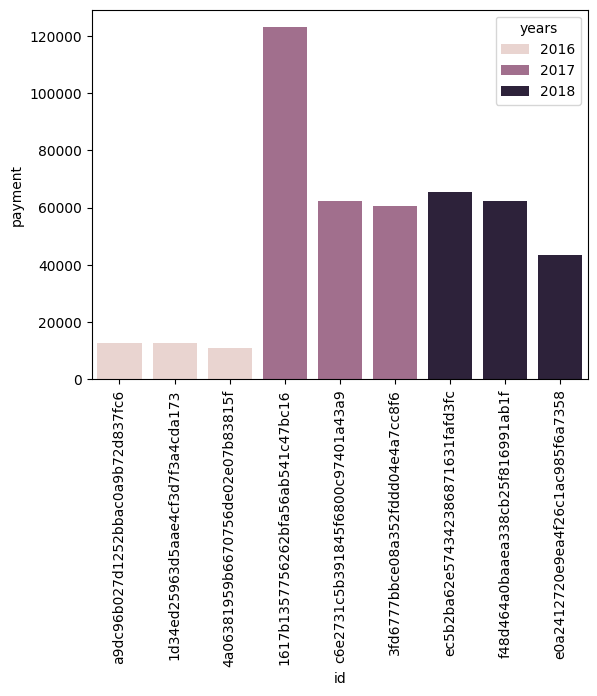

In [17]:
query="""select years,customer_id,payment,d_rank
from
(select year(orders.order_purchase_timestamp)years,
orders.customer_id,
sum(payments.payment_value)payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value)desc)d_rank
from orders join payments
on payments.order_id=orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id)as a
where d_rank<=3;"""
cur.execute(query)
data=cur.fetchall() 
df=pd.DataFrame(data,columns=["years","id","payment","rank"])
sns.barplot(x="id",y="payment",data=df,hue="years")
plt.xticks(rotation=90)